In [2]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

from functools import partial

In [3]:
from functools import partial
l1_norm = partial(np.linalg.norm, ord=1, axis=-1)

class FuzzyART(object):
    def __init__(self, alpha=1.0, vigi=0.5, gamma = 0.01):
        """        
        :param alpha: learning rate [0,1] 
        :param gamma: regularization term > 0
        :param vigi: vigilance [0,1]
        """
        self.alpha = alpha
        self.gamma = gamma
        self.vigi = vigi  

    def normalize(self, vector):
        return sum(abs(x) for x in vector)

    def init_weights(self, x):
        self.w = np.atleast_2d(x)

    def complement_code(self, x):
        return np.hstack((x, 1-x))
    
    def add(self,x):
        self.w = np.vstack((self.w, x))

    def match(self, x):
        weights = np.minimum(x, self.w)
        fuzzy_norm = l1_norm(weights)  # |x ∧ w_j|
        w_norm = l1_norm(self.w)       # |w_j|
        x_norm = np.sum(np.abs(x))            # |x|
        match_values = fuzzy_norm / x_norm
        T_scores = fuzzy_norm / (self.gamma + w_norm)
        best_score = -np.inf
        best_category = -1

        for i, score in enumerate(T_scores):
            if match_values[i] >= self.vigi:
                if score > best_score:
                    best_score = score
                    best_category = i

        return best_category
    
    def train(self, x, epochs=1):
        # x is a 2d array of size (samples, features)
        samples = self.complement_code(np.atleast_2d(x))

        self.init_weights(samples[0])

        for epoch in range(epochs):
            for sample in np.random.permutation(samples):
                category = self.match(sample)
                if category == -1:
                    self.add(sample)
                else:
                    w = self.w[category]
                    self.w[category] = (self.alpha * np.minimum(sample, w)) + ((1 - self.alpha) * w)

        return self
    
    def test(self, x):
        samples = self.complement_code(np.atleast_2d(x))

        categories = np.zeros(len(samples))
        for i, sample in enumerate(samples):
            categories[i] = self.match(sample)
        return categories

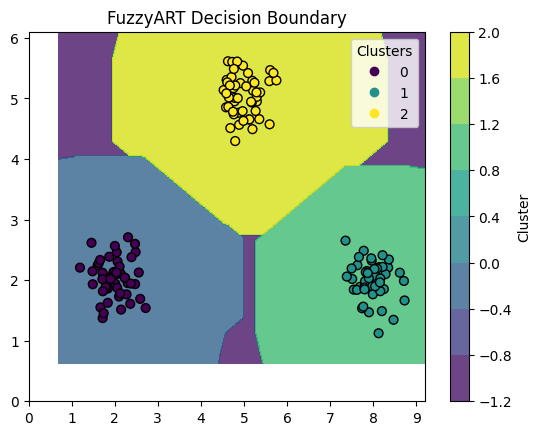

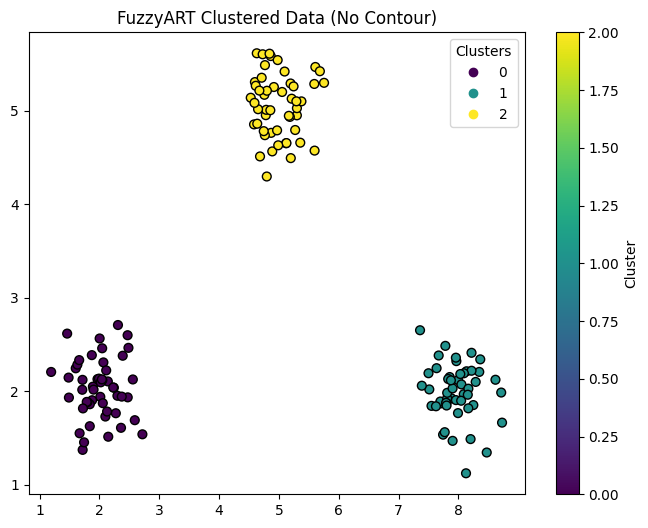

Number of categories formed: 3


In [4]:
np.random.seed(0)

mean1 = [2, 2]
cov1 = [[0.1, 0], [0, 0.1]]
data1 = np.random.multivariate_normal(mean1, cov1, 50)

mean2 = [5, 5]
cov2 = [[0.1, 0], [0, 0.1]]
data2 = np.random.multivariate_normal(mean2, cov2, 50)

mean3 = [8, 2]
cov3 = [[0.1, 0], [0, 0.1]]
data3 = np.random.multivariate_normal(mean3, cov3, 50)

data = np.vstack((data1, data2, data3))

x_min = data.min(axis=0)
x_max = data.max(axis=0)
data_norm = (data - x_min) / (x_max - x_min)

art = FuzzyART(alpha=1.0, vigi=0.6, gamma=0.01)

art.train(data_norm, epochs=1)

categories = art.test(data_norm)

def predict(vigi, grid_data, art_instance):
    art_instance.vigi = vigi
    grid_data_norm = (grid_data - x_min) / (x_max - x_min)
    categories = art_instance.test(grid_data_norm)
    return categories

def plot_fill_decision_boundary(predict, X, y, art_instance, vigi, xlabel='', ylabel=''):
    buffer = 0.5
    x_min_plot, x_max_plot = X[:, 0].min() - buffer, X[:, 0].max() + buffer
    y_min_plot, y_max_plot = X[:, 1].min() - buffer, X[:, 1].max() + buffer
    xx, yy = np.meshgrid(np.arange(x_min_plot, x_max_plot, 0.02), np.arange(y_min_plot, y_max_plot, 0.02))
    grid_data = np.c_[xx.ravel(), yy.ravel()]
    y_hat = predict(vigi, grid_data, art_instance)
    y_hat = y_hat.reshape(xx.shape)
    contour = plt.contourf(xx, yy, y_hat, alpha=0.8, cmap='viridis')
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=40, cmap='viridis')
    cbar = plt.colorbar(contour)
    cbar.set_label('Cluster')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(np.floor(x_min_plot), np.ceil(x_max_plot), step=1))
    plt.yticks(np.arange(np.floor(y_min_plot), np.ceil(y_max_plot), step=1))
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.title('FuzzyART Decision Boundary')

def plot_scatter_decision_boundary(X, y, xlabel='', ylabel=''):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=40, cmap='viridis')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(np.floor(X[:, 0].min()), np.ceil(X[:, 0].max()), step=1))
    plt.yticks(np.arange(np.floor(X[:, 1].min()), np.ceil(X[:, 1].max()), step=1))
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.title('FuzzyART Clustered Data (No Contour)')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Cluster')
    plt.show()

plot_fill_decision_boundary(predict, data, categories, art, art.vigi)
plot_scatter_decision_boundary(data, categories)

print("Number of categories formed:", len(np.unique(categories)))